Alternate Catalog Test 1: 

In redshift bins of width 0.001 (or 0.005), identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-bin joint fit to calibrate the TFR at $0.4R_{26}$, weighting the galaxies in the fit by $V(z=0.2)/V_{max}$.  Only use those galaxies which HDBSCAN identifies as being part of the central population. Then, generate a catalog of the logdistance ratios for these galaxies.

Version: **10 November 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, FlatLambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c
from astropy.io import fits

from cosmoprimo.fiducial import DESI

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm
from hdbscan import HDBSCAN
from scipy.stats import binned_statistic
from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '../'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_corr-20251030.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.5690596280100633e-05,122.32238811543634,10.869518800965125,N
55,SGA-2020 55,PGC1203

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [4]:
Planck18_h = FlatLambdaCDM(H0=100, Om0=0.3151)

In [5]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

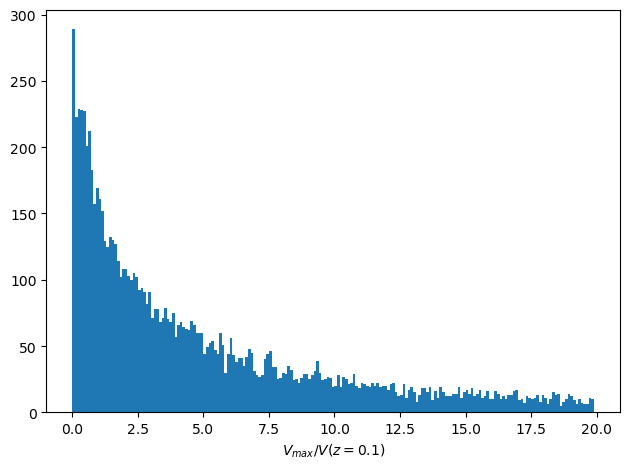

In [6]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

## Convert to CMB frame

In [7]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [8]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '../'
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [9]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [10]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [11]:
lucey_VIpath = '../VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [12]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [13]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB,MORPHTYPE_AI,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,str10,str6
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.761488

# Photometric corrections

### Survey offsets

In [14]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [15]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [16]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/u1/s/sgmoore1/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [17]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [18]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [19]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [20]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [21]:
temp_infile = open('../iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [22]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [23]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [24]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [25]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology
* Not an outlier (as found in the `TF_Y1_clustering.ipynb` notebook)

The first 2.5 items have already been applied (our VI results have already been applied, but not John's).

In [38]:
sgatab['MU_ZCMB'] = Planck18_h.distmod(sgatab['Z_DESI_CMB'])

sgatab['R_ABSMAG_SB26'] = sgatab['R_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value

data = np.array([sgatab['R_ABSMAG_SB26'], np.log10(sgatab['V_0p4R26'])])

clusterer = HDBSCAN(cluster_selection_epsilon=0.07)

clusterer.fit(data.T)

outlier_boolean = clusterer.labels_ != 9
# This limit was determined in the TF_Y1_clustering.ipynb notebook

In [39]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John & ~outlier_boolean

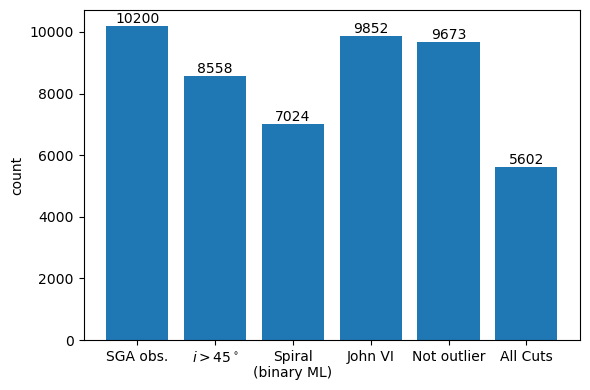

In [40]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    # 'Not dwarf' : np.sum(~dwarf_boolean), 
    'Not outlier' : np.sum(~outlier_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Redshift bins

Separate the galaxies into redshift bins of width 0.005, starting at a redshift of 0.03.  (PVs are a significant fraction of the redshift at redshifts less than this.)

In [75]:
zmin = 0.03
zmax = 0.1
dz = 0.005
zbins = np.arange(zmin, zmax+dz, dz)

#- SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

zbin_indices = np.digitize(sgatab_sel['Z_DESI_CMB'], zbins, right=True)

In [76]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')

 0  z <= 0.030  670 galaxies
 1  0.030 < z <= 0.035  413 galaxies
 2  0.035 < z <= 0.040  343 galaxies
 3  0.040 < z <= 0.045  346 galaxies
 4  0.045 < z <= 0.050  368 galaxies
 5  0.050 < z <= 0.055  364 galaxies
 6  0.055 < z <= 0.060  315 galaxies
 7  0.060 < z <= 0.065  345 galaxies
 8  0.065 < z <= 0.070  328 galaxies
 9  0.070 < z <= 0.075  304 galaxies
10  0.075 < z <= 0.080  305 galaxies
11  0.080 < z <= 0.085  307 galaxies
12  0.085 < z <= 0.090  254 galaxies
13  0.090 < z <= 0.095  170 galaxies
14  0.095 < z <= 0.100  126 galaxies
15  0.100 < z <= 0.105  136 galaxies
16  z > 0.105  508 galaxies


In [77]:
_, counts = np.unique(zbin_indices, return_counts=True)

print(np.min(counts[1:-1]), np.max(counts[1:-1]))

126 413


# Build the Calibration Table of SGA Galaxies

In [78]:
sgatab_sel['Z_BIN_IDX'] = zbin_indices

no_use = (zbin_indices == 0) | (zbin_indices == len(zbins))
caltab = sgatab_sel[~no_use]

rejtab = sgatab_sel[no_use]

# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony2_dVsys.fits', overwrite=True)
caltab[['Z_BIN_IDX', 'Z_DESI_CMB', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_ERR']]

Z_BIN_IDX,Z_DESI_CMB,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_ERR
int64,float64,float64,float64,float64,float64,float64
11,0.08162327483927467,38.0,16.715230672882495,0.10979378599642392,122.32238811543634,10.869518800965125
13,0.09120074612338591,117.0,15.939735652981327,0.11303674684848602,180.65572517100514,13.281536295531684
4,0.04770393135250317,1158.0,14.797074942719192,0.10821215940387177,177.6605660298364,10.878704878309893
2,0.03730090242889217,1289.0,15.15512869185768,0.13607703661955411,69.54198266184605,26.914651455106853
6,0.05517343391109497,1358.0,14.473279440148362,0.06547763407431081,199.70906692232123,6.994075041243547
7,0.06211147463081468,1548.0,16.42100724216234,0.09659160458203309,169.13249088380044,11.414839425129315
6,0.05541189869150731,1663.0,16.268923061483076,0.13530476424196208,140.65284037083947,10.67103269233122
10,0.07868601783175921,1849.0,15.15410470187664,0.07192519244976477,224.5875972323314,8.330015749448037
4,0.048805933559745496,1996.0,16.64281198670305,0.08932478821601378,125.94703384316176,12.63905939086584


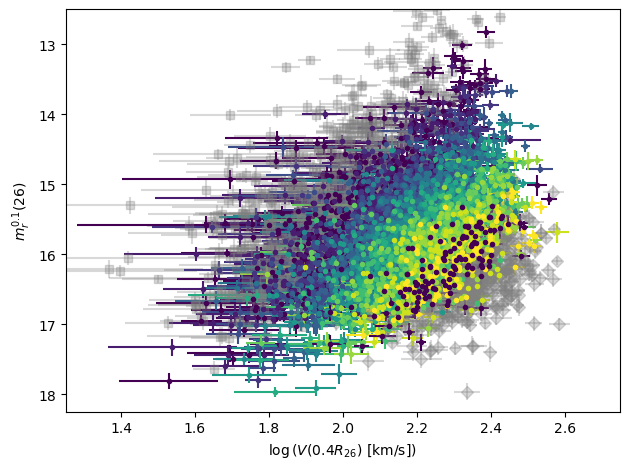

In [79]:
# fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)
fig, axes = plt.subplots(1, 1, tight_layout=True)

logV0 = 0

# ax = axes[0] 
ax = axes

#-------------------------------------------------------------------------------
# Plot galaxies with failed cluster selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(rejtab['Z_BIN_IDX'])
markers = 'sDv^<>'
for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(rejtab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_zbin].data / rejtab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_zbin].data

    if _zbin_id == 0:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z $\leq$ {zbins[_zbin_id]:.3f} (rej.)')
    else:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z > {zbins[_zbin_id-1]:.3f} (rej.)')
#-------------------------------------------------------------------------------
# Plot galaxies and clusters passing all selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,len(_zbin_ids)+1)))

for _zbin_id in _zbin_ids:
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_ERR'][select_zbin].data / caltab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_zbin].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', 
                label=f'{zbins[_zbin_id-1]:.3f}-{zbins[_zbin_id]:.3f}')
#-------------------------------------------------------------------------------

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[18.25, 12.5],
       ylabel=r'$m_r^{0.1} (26)$');

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [80]:
#- Extract successful clusters
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.log10(caltab['V_0p4R26']))
print('logV0 =', logV0)

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['R_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

logV0 = 2.1771419310572777


## Multiline Fit using HyperFit

In [81]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += m*[(-20, 20)]                # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -1084498.5648557679
     jac: array([  2.00234355,  -1.74622968,  -6.96163567,  -2.56113687,
         2.93366587,  -4.14438511, -20.74520863,  11.85107878,
        -4.07453593,  16.76380496,   2.74740137, -12.38658922,
         2.02562643,   5.63450111,  -7.72997673,  -4.49363105,
        97.60260587])
 message: 'Optimization terminated successfully.'
    nfev: 47553
     nit: 184
 success: True
       x: array([-6.53144197, 14.48977534, 14.76665927, 14.97299392, 15.21386395,
       15.43169425, 15.61358642, 15.78890795, 15.94787329, 16.08197436,
       16.23050031, 16.39445908, 16.50960807, 16.74991901, 16.92766034,
       16.86213663,  0.42309812])
Ndim: 17 15


100%|██████████| 1000/1000 [00:53<00:00, 18.70it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [72.16611501 49.98647109 60.35899602 53.72201317 54.1745419  51.13377931
 81.21857146 65.16285922 59.41959461 64.51818899 61.91003011 62.90805127
 73.26660941 72.90885642 71.18334537 75.49602134 70.49490309] / 4060.928573106677


100%|██████████| 1000/1000 [00:50<00:00, 19.71it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [87.02147741 53.16839602 65.7399893  61.61408221 65.61391575 61.32941404
 71.73655678 74.05193399 77.80739623 75.26284585 75.4889095  82.44009379
 78.46257444 84.36343713 95.64928552 99.76044614 93.51521679] / 4988.022306870228


100%|██████████| 1000/1000 [00:50<00:00, 19.74it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 98.71839225  54.99182658  67.78172651  61.11662452  64.12405193
  73.64947073  83.4019571   79.33985952  88.23309413  89.90244886
  94.3166066   94.5178145   92.67295959 106.7490743   95.39934149
 113.2550445   98.43592495] / 5662.752224897622


100%|██████████| 1000/1000 [00:50<00:00, 19.62it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [114.13543506  55.19280044  68.9221866   69.85560988  64.06061115
  76.13075414  85.36324937  81.290362    93.99663116 104.20842472
  98.55137934  93.27907609 101.17359153 109.69832157 112.00004319
 124.47915143 109.30969279] / 6223.957571729726


100%|██████████| 1000/1000 [00:49<00:00, 20.26it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [115.78981491  57.39261189  69.46021173  70.08314696  65.64891297
  74.30899645  86.99218659  89.79317977 103.91686374 105.89406421
  99.06900632  96.1854287  110.99330656 124.40786304 127.05040366
 132.85775815 116.5679539 ] / 6642.8879073617


100%|██████████| 1000/1000 [00:51<00:00, 19.60it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [122.74147241  63.68882358  73.19958275  74.51525861  72.15161072
  77.60027986  85.15424501  83.54802444 103.29588718 105.43647982
 102.37547455 101.35914977 110.78589814 126.58899381 140.23995262
 135.98041513 130.6903338 ] / 7011.997631062238


100%|██████████| 1000/1000 [00:53<00:00, 18.84it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [130.76766352  64.7735382   71.78933739  78.20845319  73.76472382
  77.46935483  89.9500945   82.98515221 108.99619599 110.94605965
  98.67309415 104.7580689  117.31947377 129.58791164 134.48337297
 138.18550193 134.96821565] / 6909.275096289267


100%|██████████| 1000/1000 [00:51<00:00, 19.52it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [133.73124011  66.3641141   75.71065968  78.5934162   82.26013745
  75.19815897  91.60244835  85.79491371 102.81627718 117.33108377
 103.41179804 112.97778798 130.16165584 133.59817421 125.44062044
 135.94759517 143.37737018] / 7168.86850896038


100%|██████████| 1000/1000 [00:50<00:00, 19.72it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [143.35490301  64.95900458  75.22672581  73.46818989  85.5279411
  75.16836131  93.80279374  86.7864634  105.21797688 114.38429463
 104.12238933 109.79180605 136.88280154 145.42712842 137.65237825
 143.41682979 147.91808475] / 7395.904237417492


100%|██████████| 1000/1000 [00:50<00:00, 19.65it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [138.57304207  63.87797893  81.67753522  76.27027045  82.5987419
  77.7732915   93.42551732  86.96944943 108.99242272 113.77010646
 108.56533045 110.90849583 140.33881049 144.43083812 134.97244029
 143.71793509 148.55358419] / 7427.679209471833


100%|██████████| 1000/1000 [00:51<00:00, 19.25it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [148.02974167  66.10455454  83.16439308  73.19271449  78.56153093
  79.02268711  93.52830848  84.40859982 107.35741731 117.88980441
 109.14542588 114.96206754 138.31476975 143.27234239 138.16483695
 142.84113342 151.8112714 ] / 7590.5635702065865


100%|██████████| 1000/1000 [00:51<00:00, 19.59it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [157.27018337  65.67315891  82.1009468   72.80061842  79.2197716
  77.96036853  93.45160629  84.55747421 112.84062449 121.78867231
 115.09481447 117.10519215 132.30781268 149.04946478 139.83520232
 142.17471778 153.98814715] / 7863.509168567705


100%|██████████| 1000/1000 [00:51<00:00, 19.51it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [163.89382329  63.40672066  81.58499101  72.85679446  81.73627073
  80.06450087  91.35708742  86.53695407 108.33772708 116.45652797
 117.74307989 117.68989618 137.97812246 153.82550268 137.28349202
 144.53998787 165.15869467] / 8257.934733501623


100%|██████████| 1000/1000 [00:51<00:00, 19.27it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [157.49927652  66.60266658  84.27931962  74.30050591  81.26140145
  83.03082289  95.03022446  90.1250895  110.8989872  116.46272431
 124.61500749 113.99500883 135.99702858 152.78124274 131.67667943
 147.72981936 165.27520671] / 8263.760335661429


100%|██████████| 1000/1000 [00:52<00:00, 19.20it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [157.16877678  63.58756184  83.42524974  72.79254771  81.48176472
  81.42552521  93.21157984  93.47613355 109.68240365 117.09847789
 119.16026229 116.75427553 142.39339348 155.03016176 133.95600539
 145.00802512 165.8531842 ] / 8292.65921023886


In [48]:
temp_outfile = open('/pscratch/sd/s/sgmoore1/TF/pickles/cov_ab_iron_jointTFR_systematics_test1.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins), temp_outfile)
temp_outfile.close()

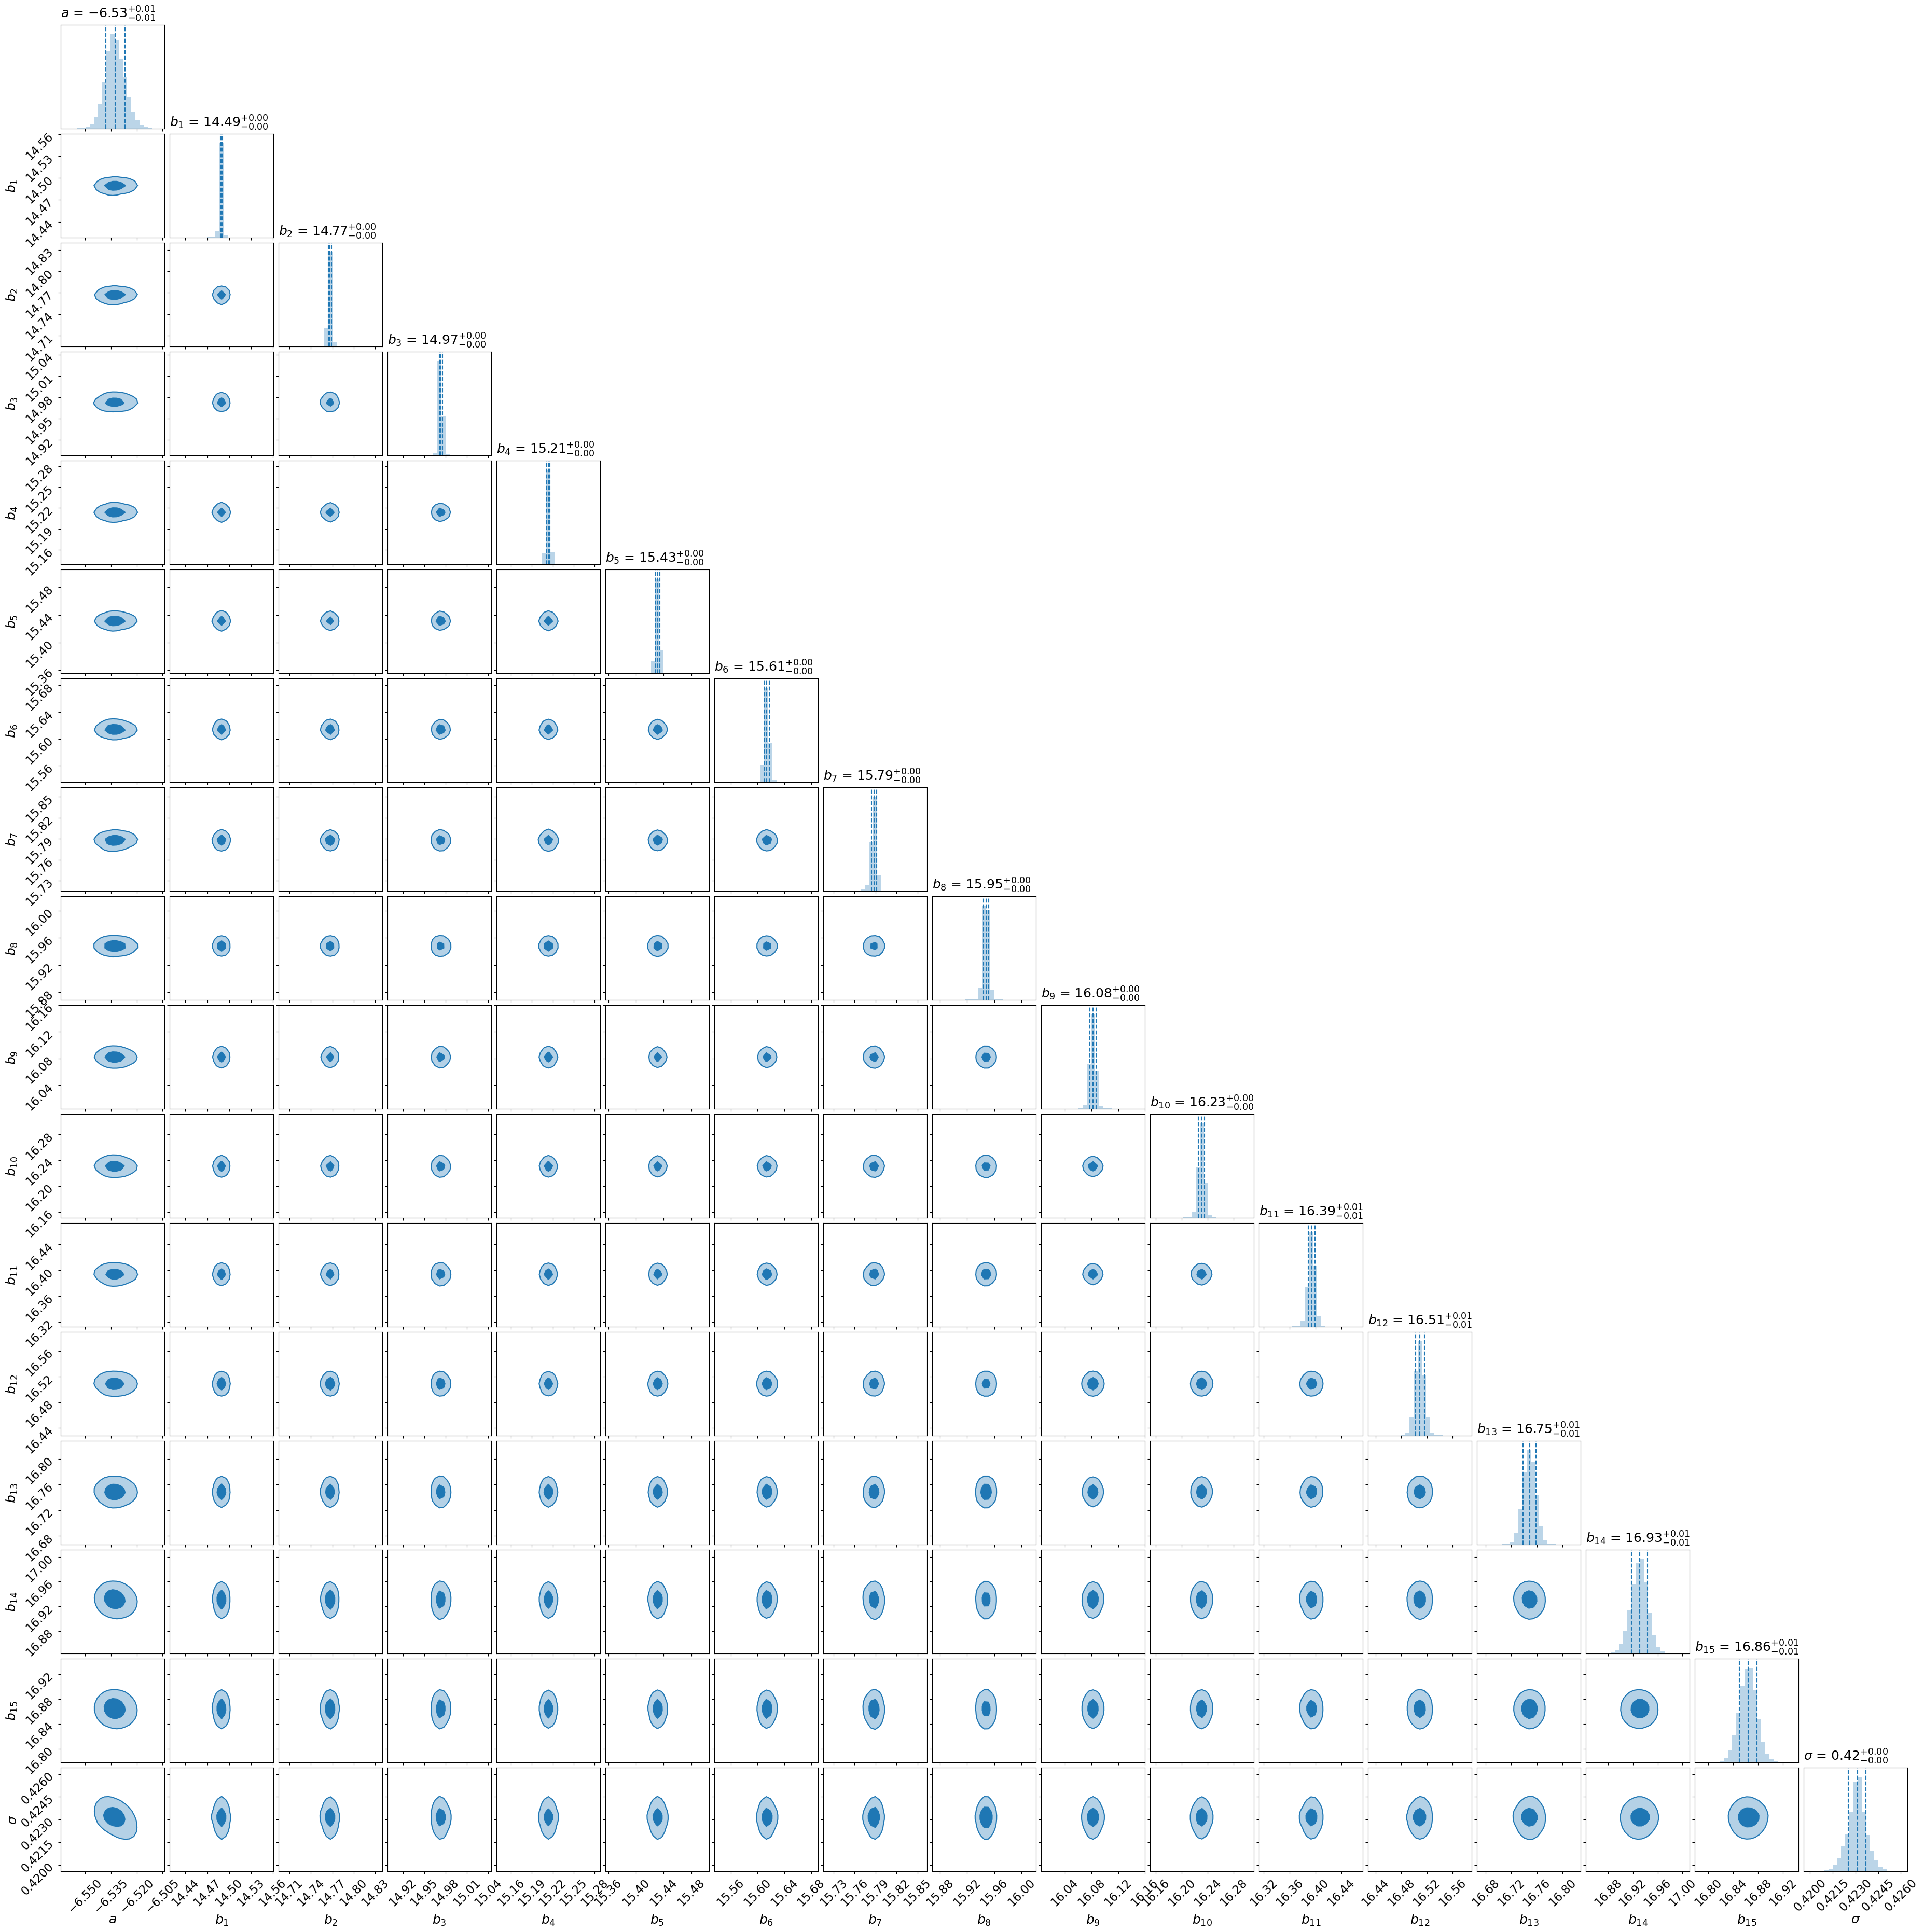

In [82]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [83]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
# for k in range(1, m+2):
for k in range(1, m+1):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

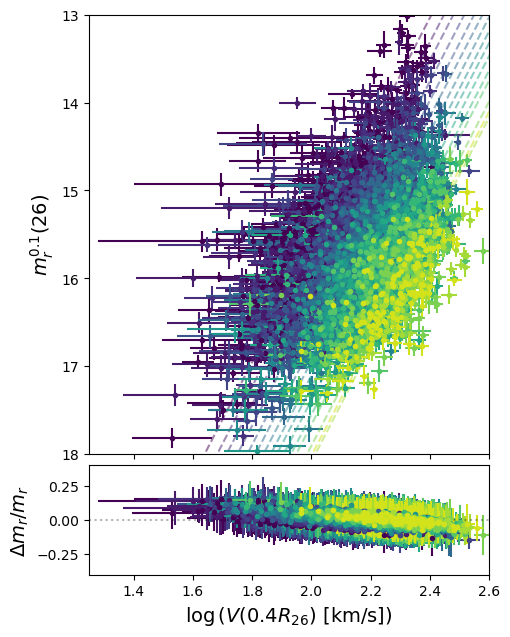

In [84]:
# fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
# b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1]#[1:]

#- Plot redshift bins
# ax = axes[0,0]
ax = axes[0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV0 + logV[k],#+1], 
                     y=mag[k],#+1], 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.25, 2.6],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);
'''
#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', color='tab:blue', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.25, 2.6],
       ylim=[-18, -24]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)
'''
#- Plot residuals: z-bins
# ax = axes[1,0]
ax = axes[1]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k]#+1]
    m_obs = mag[k]#+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)
'''
#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                xerr=logV_err[0], yerr=mag_err[0],
                fmt='.', color='tab:blue')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)
'''
fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

In [85]:
print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.61 +/- 0.002


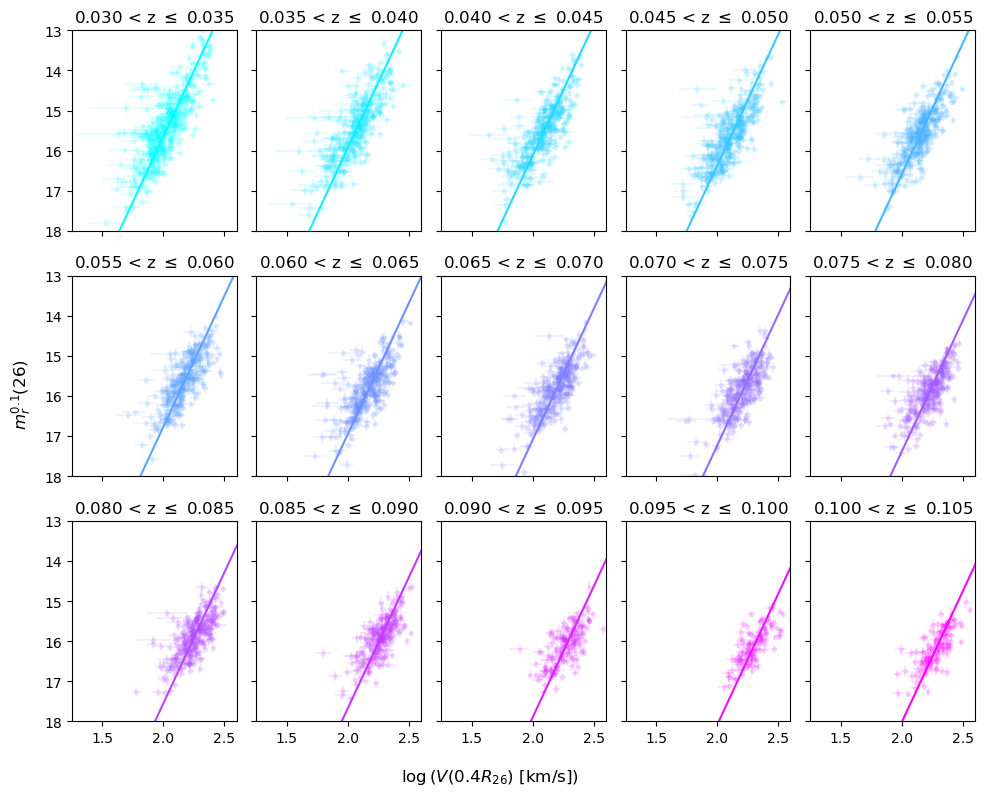

In [86]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axs[row,col].errorbar(logV0 + logV[i],#+1], 
                               mag[i],#+1], 
                               xerr=logV_err[i],#+1], 
                               yerr=mag_err[i],#+1], 
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

# Calculate logdistance ratios

In [87]:
cosmo = FlatLambdaCDM(H0=H0, Om0=0.3151)
# cosmo = DESI()

sgatab['MU_ZCMB'] = cosmo.distmod(sgatab['Z_DESI_CMB'])

sgatab['R_ABSMAG_SB26'] = sgatab['R_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value

In [88]:
rng = np.random.default_rng()

N_samples = 1000

mu_err = np.empty(len(sgatab['MU_ZCMB']))*u.mag

for i in tqdm(range(len(mu_err))):
    
    z_desi_random = rng.normal(np.abs(sgatab['Z_DESI_CMB'][i]), 
                               sgatab['ZERR_DESI'][i], 
                               N_samples)
    
    mu_random = cosmo.distmod(z_desi_random)
    
    mu_err[i] = np.std(mu_random)

sgatab['MU_ZCMB_ERR'] = mu_err

sgatab['R_ABSMAG_SB26_ERR'] = np.sqrt(sgatab['R_MAG_SB26_ERR_CORR']**2 + sgatab['MU_ZCMB_ERR'].value**2)

100%|██████████| 10200/10200 [00:09<00:00, 1101.70it/s]


In [89]:
# Center redshift values of each bin
zc = 0.5*dz + zbins[:-1]

# Distance modulus for each redshift bin center
mu_zc = cosmo.distmod(zc)

In [90]:
slope = np.median(tfr_mcmc_samples[0])
slope_err = np.sqrt(cov_tfr[0,0])

# Each redshift bin has its own 0pt
# To put it in absolute-magnitude space, we'll convert it to an absolute magnitude using the middle of the redshift bin
ZP = np.median(tfr_mcmc_samples[1:-1], axis=1) - mu_zc.value
ZP_err = np.sqrt(np.diagonal(cov_tfr[1:-1,1:-1])) # Should include z-bin width to this uncertainty

sig = np.median(tfr_mcmc_samples[-1])

logv = np.linspace(-1*np.ones(len(zbins)-1), 3.5*np.ones(len(zbins)-1), 100)
absmag = slope*(logv - logV0) + ZP

In [91]:
spiral_boolean = sgatab['MORPHTYPE_AI'] == 'Spiral'
irregular_boolean = sgatab['MORPHTYPE_AI'] == 'Irregular'
# other_boolean = sgatab['MORPHTYPE_AI'] == 'Other'

VI_boolean = sgatab['JOHN_VI'].mask

morph_boolean = (spiral_boolean | irregular_boolean) & VI_boolean

In [92]:
sgatab['GOOD_MORPH'] = morph_boolean

print(sum(outlier_boolean), 'outliers')
print(sum(~outlier_boolean), 'non-outliers')
print('-----------')
print(np.sum(morph_boolean), 'spirals & irregulars that pass VI')
print(np.sum(morph_boolean & outlier_boolean), 'outliers')
print(np.sum(morph_boolean & ~outlier_boolean), 'non-outliers')

527 outliers
9673 non-outliers
-----------
9212 spirals & irregulars that pass VI
406 outliers
8806 non-outliers


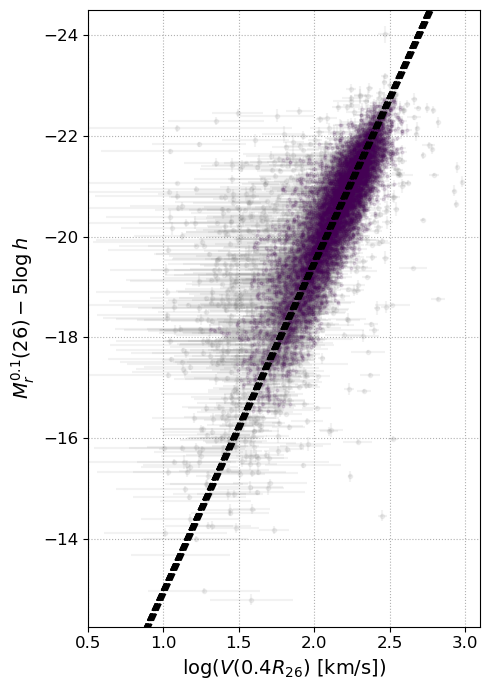

In [93]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = outlier_boolean# & morph_boolean
plt.errorbar(np.log10(sgatab['V_0p4R26'][sample]), 
             sgatab['R_ABSMAG_SB26'][sample], 
             xerr=0.434*sgatab['V_0p4R26_ERR'][sample]/sgatab['V_0p4R26'][sample],
             yerr=sgatab['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean# & morph_boolean
plt.errorbar(np.log10(sgatab['V_0p4R26'][sample]), 
             sgatab['R_ABSMAG_SB26'][sample], 
             xerr=0.434*sgatab['V_0p4R26_ERR'][sample]/sgatab['V_0p4R26'][sample],
             yerr=sgatab['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             markersize=4, 
             alpha=0.1, 
             ecolor='gray')

# sample = ~outlier_boolean_alt & outlier_boolean
# plt.errorbar(np.log10(sgatab['V_0p4R26'][sample]), 
#              sgatab['R_ABSMAG_SB26'][sample], 
#              xerr=0.434*sgatab['V_0p4R26_ERR'][sample]/sgatab['V_0p4R26'][sample],
#              yerr=sgatab['R_ABSMAG_SB26_ERR'][sample], 
#              fmt='.', 
#              markersize=4, 
#              alpha=0.2, 
#              ecolor='gray')



plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -24.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_jointTFR_varyV0-perpdwarf_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none')

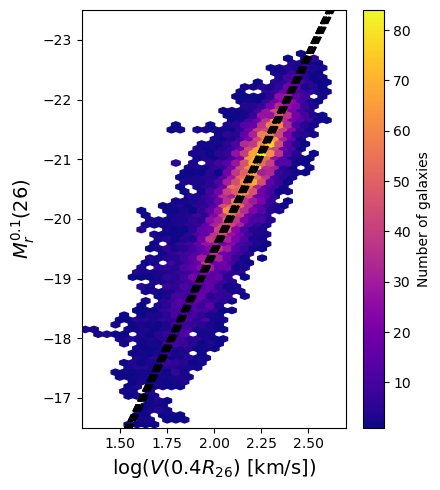

In [94]:
plt.figure(figsize=(4.5,5), tight_layout=True)

plt.hexbin(np.log10(sgatab['V_0p4R26'][~outlier_boolean]), 
           sgatab['R_ABSMAG_SB26'][~outlier_boolean], 
           cmap='plasma', 
           mincnt=1, 
           gridsize=(70,80), 
           extent=(-0.1, 3.1, -25, -12.25))
plt.colorbar(label='Number of galaxies')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([1.3, 2.7])
plt.ylim([-16.5, -23.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26)$', fontsize=14);

#### Redshift distribution

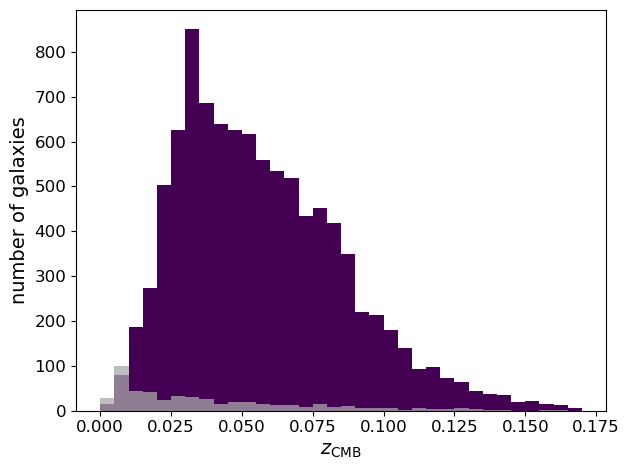

In [95]:
plt.figure(tight_layout=True)

plt.hist(sgatab['Z_DESI_CMB'][~outlier_boolean],
         bins=np.arange(0, 0.175, 0.005))
plt.hist(sgatab['Z_DESI_CMB'][outlier_boolean],
         bins=np.arange(0, 0.175, 0.005), 
         color='darkgray',
         alpha=0.75)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14);

# Distance moduli

In [96]:
# First, match each galaxy to its redshift bin
zbin_indices = np.digitize(sgatab['Z_DESI_CMB'], zbins, right=True)

# For those galaxies that fall outside the calibration range, assign them to the closest bin
zbin_indices[zbin_indices == 0] = 1
zbin_indices[zbin_indices == len(zbins)] = len(zbins) - 1

# Then, use that galaxy's redshift bin's zero-point to calculate the distance modulus
sgatab['R_ABSMAG_SB26_TF'] = np.nan
for i in range(len(sgatab)):
    sgatab['R_ABSMAG_SB26_TF'][i] = slope*(np.log10(sgatab['V_0p4R26'][i]) - logV0) + ZP[zbin_indices[i] - 1]

In [97]:
sgatab['R_ABSMAG_SB26_TF_ERR'] = np.nan
sgatab['R_ABSMAG_SB26_TF_ERR_STAT'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(sgatab))):
    
    v_random = rng.normal(sgatab['V_0p4R26'][i], 
                          sgatab['V_0p4R26_ERR'][i], 
                          size=10000
                          # size=len(slopes)
                         )
    # logv_random = rng.normal(np.log10(sgatab['V_0p4R26'][i]), 
    #                          0.434*sgatab['V_0p4R26_ERR'][i]/sgatab['V_0p4R26'][i], 
    #                          size=len(slopes))

    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = slope*(np.log10(v_random[v_random > 0]) - logV0) + ZP[zbin_indices[i] - 1]
    # Ms_stat = slope*(logv_random - V0) + ZP

    sgatab['R_ABSMAG_SB26_TF_ERR_STAT'][i] = np.nanstd(Ms_stat)
    ############################################################################

    
    ############################################################################
    # Total uncertainty
    #
    # THIS NEEDS TO BE UPDATED TO INCLUDE THE SLOPE & Y-INTERCEPT UNCERTAINTIES
    #---------------------------------------------------------------------------
    # Ms = slopes[v_random > 0]*(np.log10(v_random[v_random > 0]) - V0) + ZPs[v_random > 0]
    # Ms = slopes*(logv_random - V0) + ZPs
    
    # sgatab['R_ABSMAG_SB26_TF_ERR'][i] = np.nanstd(Ms)
    sgatab['R_ABSMAG_SB26_TF_ERR'][i] = np.sqrt(sgatab['R_ABSMAG_SB26_TF_ERR_STAT'][i]**2 + sig**2)
    ############################################################################
    

################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
sgatab['R_ABSMAG_SB26_TF_ERR_SYS'] = np.sqrt(sgatab['R_ABSMAG_SB26_TF_ERR']**2 - sgatab['R_ABSMAG_SB26_TF_ERR_STAT']**2)
################################################################################

100%|██████████| 10200/10200 [00:03<00:00, 2744.81it/s]


In [98]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

/tmp/ipykernel_326076/3818747994.py:50: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt((mean2 - mean**2) / (N - 1))


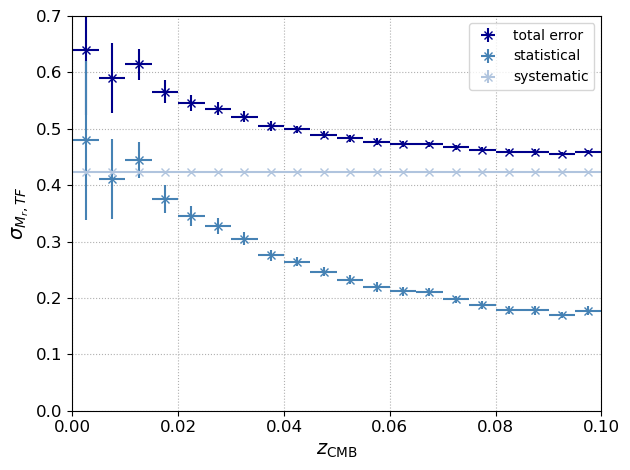

In [99]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

plt.figure(tight_layout=True)

# plt.plot(tf_data['Z_DESI_CMB'][sample1], tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], '.', alpha=0.1)

# Total uncertainty
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_ABSMAG_SB26_TF_ERR'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='total error')

# Statistical uncertainty (just from velocity uncertainty)
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_ABSMAG_SB26_TF_ERR_STAT'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='steelblue', label='statistical')

# Systematic uncertainty (from TF calibration)
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_ABSMAG_SB26_TF_ERR_SYS'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='systematic')

plt.grid(ls=':')

plt.legend()

plt.xlim(0, 0.1)
plt.ylim(0, 0.7)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\sigma_{M_r, TF}$', fontsize=14);

## Compute distance modulus based on our TFR

In [100]:
sgatab['MU_TF'] = sgatab['R_MAG_SB26_CORR'] - sgatab['R_ABSMAG_SB26_TF']

sgatab['MU_TF_ERR'] = np.sqrt(sgatab['R_MAG_SB26_ERR_CORR']**2 + sgatab['R_ABSMAG_SB26_TF_ERR']**2)

## $\Delta M_r$ v. redshift

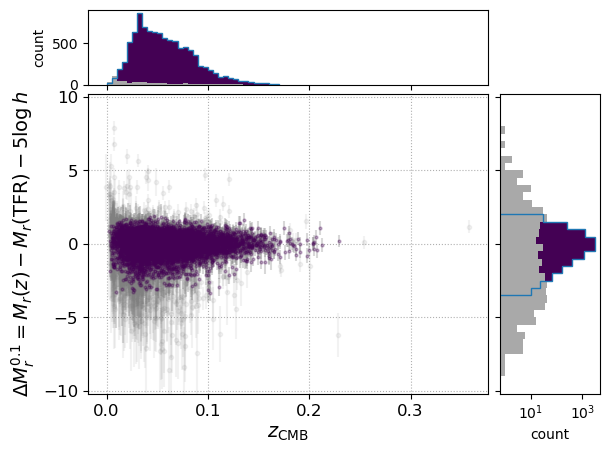

In [101]:
fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

sample = outlier_boolean# & morph_boolean
ax.errorbar(sgatab['Z_DESI_CMB'][sample], 
             sgatab['R_ABSMAG_SB26'][sample] - sgatab['R_ABSMAG_SB26_TF'][sample], 
             xerr=sgatab['ZERR_DESI'][sample], 
             yerr=sgatab['MU_TF_ERR'][sample],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean
ax.errorbar(sgatab['Z_DESI_CMB'][sample], 
             sgatab['R_ABSMAG_SB26'][sample] - sgatab['R_ABSMAG_SB26_TF'][sample], 
             xerr=sgatab['ZERR_DESI'][sample], 
             yerr=sgatab['MU_TF_ERR'][sample],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\Delta M_r^{0.1} = M_r(z) - M_r(\text{TFR}) - 5\log h$', fontsize=14)

ax.set_ylim((-10.2, 10.2))


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(sgatab['Z_DESI_CMB'][~outlier_boolean],
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(sgatab['Z_DESI_CMB'][outlier_boolean],
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(sgatab['Z_DESI_CMB'][~outlier_boolean],
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
sample1 = ~outlier_boolean
sample2 = outlier_boolean
ax_histy.hist(sgatab['R_ABSMAG_SB26'][sample1] - sgatab['R_ABSMAG_SB26_TF'][sample1], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal')
ax_histy.hist(sgatab['R_ABSMAG_SB26'][sample2] - sgatab['R_ABSMAG_SB26_TF'][sample2], 
              bins=np.arange(-12.5, 10, 0.5), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(sgatab['R_ABSMAG_SB26'][sample1] - sgatab['R_ABSMAG_SB26_TF'][sample1], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

## $\eta$ v. redshift

In [102]:
sgatab['LOGDIST'] = 0.2*(sgatab['MU_ZCMB'] - sgatab['MU_TF'])
sgatab['LOGDIST_ERR'] = 0.2*np.sqrt(sgatab['MU_ZCMB_ERR']**2 + sgatab['MU_TF_ERR']**2)

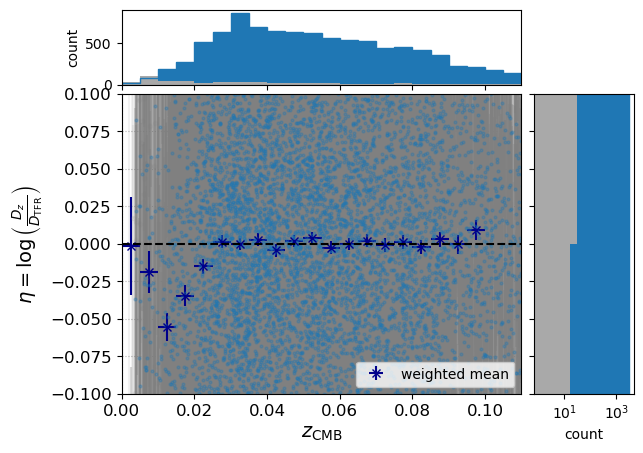

In [103]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

ax.errorbar(sgatab['Z_DESI_CMB'][sample2], 
             sgatab['LOGDIST'][sample2], 
             xerr=sgatab['ZERR_DESI'][sample2], 
             yerr=sgatab['LOGDIST_ERR'][sample2],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

ax.errorbar(sgatab['Z_DESI_CMB'][sample1], 
             sgatab['LOGDIST'][sample1], 
             xerr=sgatab['ZERR_DESI'][sample1], 
             yerr=sgatab['LOGDIST_ERR'][sample1],
             fmt='.', 
             markersize=4, 
             alpha=0.3,
             color='tab:blue',
             ecolor='gray')

# Plot the weighted mean
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=sgatab['LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')
'''
# Plot the median
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_LOGDIST'][sample1], 
                                    zbins, 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='median')
'''
# Line at eta = 0
ax.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)

ax.legend()

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1.9, 1.9))
ax.set_xlim((0, 0.2))
# ax.set_ylim((-0.5, 0.5))
ax.set_ylim((-0.1, 0.1))
ax.set_xlim((0, 0.11))

ax.grid(ls=':')


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(sgatab['Z_DESI_CMB'][sample1], 
              color='tab:blue',
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(sgatab['Z_DESI_CMB'][sample2], 
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(sgatab['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(sgatab['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1),
              color='tab:blue',
              orientation='horizontal')
ax_histy.hist(sgatab['LOGDIST'][sample2], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(sgatab['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step',
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

# plt.savefig('../../Figures/Y1/iron_logdist-v-z_jointTFR-varyV0-perpdwarfs_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

In [71]:
# Create a single column to denote which objects should be used for cosmological analysis
sgatab['OUTLIER'] = outlier_boolean
sgatab['MAIN'] = ~sgatab['OUTLIER'] & sgatab['GOOD_MORPH']

In [72]:
hdr = fits.Header()

hdr['DESI_DR'] = 'DR1'
hdr['V_RADIUS'] = '0.4 R26'
hdr['M'] = slope
hdr['M_ERR'] = slope_err
# hdr['0PT'] = ZP
# hdr['0PT_ERR'] = ZP_err
hdr['logV0'] = logV0
hdr['SIG'] = np.median(tfr_mcmc_samples[-1])
hdr['SIG_ERR'] = np.sqrt(cov_tfr[-1,-1])
hdr['H0'] = H0

empty_primary = fits.PrimaryHDU(header=hdr)

In [73]:
table_hdu = fits.BinTableHDU(data=sgatab)

hdul = fits.HDUList([empty_primary, table_hdu])

# Write results to file
hdul.writeto('SGA_iron_jointTFR_test1.fits', 
             overwrite=True)

In [ ]:
x=Table.read('SGA_iron_jointTFR_test1.fits')
print(len(x))
print(np.sum(x['MAIN']))
x[:5]

In [74]:
hdul.writeto('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/systematic_tests/DESI-DR1_TF_pv_test_cat_v1.fits', 
             overwrite=True)